In [0]:
import torch
from torch.utils.data import DataLoader,TensorDataset
print(torch.__version__)
device = torch.device('cpu')

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

## Import a pretrained Faster R-CNN model

In [0]:
from torchvision import models
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [0]:
# to put the model on GPU
model.to(device)

https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

In [0]:
# list of labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
from PIL import Image
from torchvision import transforms as T
from time import time

# used in object_detection_api
def get_prediction(img, threshold):  # accepts PIL img
    transform = T.Compose([T.ToTensor()]) # Defining PyTorch Transform as a simple conversion from PIL to Tensor
    img = transform(img) # Apply the transform to the image
    t0 = time()
    pred = model([img.to(device)]) # Pass the image to the model
    print('done in %.3fs.' % (time() - t0))
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].detach().cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Bounding boxes
    pred_score = pred[0]['scores'].detach().cpu().numpy()
    pred_t = len(pred_score[pred_score > threshold])  # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t]
    print(pred_score[:pred_t])
    pred_class = pred_class[:pred_t]
    return pred_boxes, pred_class


import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display

# THE MAIN API to predict and show
ncolors = 10
cm = plt.get_cmap('jet', ncolors)  # 10 colors
def object_detection_api(img, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_prediction(img, threshold) # Get predictions
    img = np.asarray(img)
    for i in range(len(boxes)):
        c = [int(x) for x in cm(i%ncolors, bytes=True)[:3]]
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=c, thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, c, thickness=text_th) # Write the prediction class
    display(Image.fromarray(np.uint8(img)))
    #cv2.imshow(img)
    # or
    #plt.figure(figsize=(20,30)) # display the output image
    #plt.imshow(img)
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()

## Case 1: Download and test an image on the Web

In [0]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg
img = Image.open('./car.jpg')
object_detection_api(img.resize((int(img.width/2), int(img.height/2))), rect_th=1, text_th=1, text_size=1)

## Case 2: Webcam shot and test it

In [0]:
# https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
    display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    return Image.open(f)

done in 0.168s.
[]


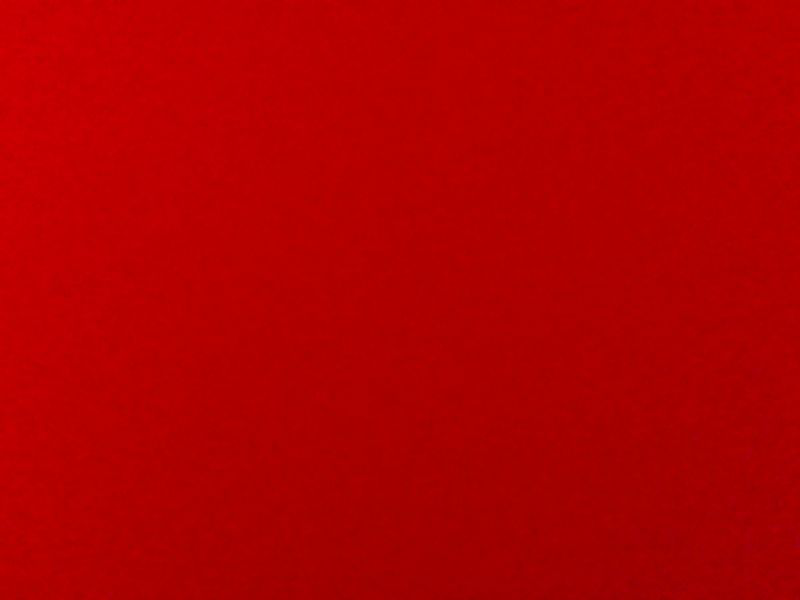

In [11]:
img = take_photo()
object_detection_api(img.resize((int(img.width/1), int(img.height/1))), rect_th=2, text_th=2, text_size=1)